In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import folium
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from folium import plugins
from folium.plugins import HeatMap
from IPython.display import display

from collections import Counter
from imblearn.over_sampling import SMOTE

# II. Data Processing

### Load tweets from csv file

The *agaton_leyte.csv* file obtained in the data gathering phase was modified such that a column called 'rating' was added. The tweets are manually assigned to different ranks for the purpose of training the classification model. These ranks are:
0 - Safe,
1 - Needs Help,
2 - Needs Immediate Help

In [270]:
df = pd.read_csv("agaton_leyte.csv", encoding='latin-1')

### Extract latitude and longitude from the coordinates column.

In [271]:
df['coordinates'] = df['coordinates'].str.replace("{'longitude':", "",regex=True)
df['coordinates'] = df['coordinates'].str.replace(", 'latitude':", "")
df['coordinates'] = df['coordinates'].str.replace("}", "", regex=True)
df['Longitude'] = df['coordinates'].str.split(' ', expand = True)[1]
df['Latitude'] = df['coordinates'].str.split(' ', expand = True)[2]

### Counts tweets in each rating
As seen below, there are 59 tweets with rank = 0, 21 tweets with rank = 1, and 20 tweets with rank = 2. This is almost a 60-20-20 split.

In [272]:
df['rating'].value_counts()

0    59
1    21
2    20
Name: rating, dtype: int64

### Split data into training data and testing data

In [273]:
X = df['content']
Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.50)

### Instantiate vectorizer and fit on the training data

*Count Vectorizer* was used to transform unigram and bigram words into vector based on the frequency of words.

In [274]:
# instantiate countfvectorizer
vect = CountVectorizer(analyzer = "word", ngram_range=(1, 2))

# fit on the training data, transform training and test data
train_data = vect.fit_transform(X_train)
test_data = vect.transform(X_test)
train_data = train_data.toarray()

print(train_data.shape)
print(test_data.shape)

(50, 1531)
(50, 1531)


### Create separate training data that uses SMOTE technique

To counter class imbalances, SMOTE is used. This oversampling technique was used as it overcomes the overfitting problem posed by random oversampling. Undersampling was not used because there are only 50 samples for the training dataset. 

A separate training datset was created by applying SMOTE to the original training dataset. By trial and error, we found that oversampling the rank-2 tweets to 13 samples generated the best precision and recall score compared to oversampling all classes to have 29 samples. 

In [275]:
counter = Counter(Y_train)
print('Before SMOTE:', counter)
strategy = {2:13}
smt = SMOTE(sampling_strategy=strategy)
train_data_sm, Y_train_sm = smt.fit_resample(train_data, Y_train)
counter2 = Counter(Y_train_sm)
print('After SMOTE:', counter2)

Before SMOTE: Counter({0: 29, 1: 13, 2: 8})
After SMOTE: Counter({0: 29, 1: 13, 2: 13})


# III. Model Building

### Using logistic regression model,

In [276]:
# Logistic Regression model
lr = LogisticRegression()
lr.fit(train_data, Y_train)

# print predictions in test data
lr_pred = lr.predict(test_data)
print(lr_pred)

[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 1 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using logistic regression model (w/ SMOTE),

In [277]:
# Logistic Regression model
lr_sm = LogisticRegression()
lr_sm.fit(train_data_sm, Y_train_sm)

# print predictions in test data
lr_pred_sm = lr_sm.predict(test_data)
print(lr_pred_sm)

[0 0 0 0 0 2 0 2 2 2 2 0 0 0 0 2 1 0 2 2 1 0 0 0 2 2 0 1 0 0 2 2 2 0 2 0 1
 0 0 0 0 0 2 2 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model,

In [278]:
# Gradient Boosting Classifier model
gb = GradientBoostingClassifier()
gb.fit(train_data, Y_train)

#print predictions in test data
gb_pred = gb.predict(test_data)
print(gb_pred)

[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model (w/ SMOTE),

In [279]:
# Gradient Boosting Classifier model
gb_sm = GradientBoostingClassifier()
gb_sm.fit(train_data_sm, Y_train_sm)

#print predictions in test data
gb_pred_sm = gb_sm.predict(test_data)
print(gb_pred_sm)

[0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 2 0 2 0 0 0
 0 0 0 0 0 2 2 0 0 0 0 0 0]


# IV. Model Evaluation
### Get the precision, recall, and f1 score of all models
Due to the nature of the dataset, precision, recall, and F-1 scores should be considered to effectively classify the performance of the minority class.

In comparing the models that were used, we first observe logistic regression and logistic regression with oversampling. There is an imbalance in recall scores because of rank 1 and rank 2 in logistic regression, but with high precision. It can also be observed that most rank 1 and rank 2 tweets were misclassified as rank 0.

In [282]:
print('--Logistic Regression--')
print(classification_report(Y_test, lr_pred))

--Logistic Regression--
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        30
           1       1.00      0.38      0.55         8
           2       1.00      0.42      0.59        12

    accuracy                           0.76        50
   macro avg       0.90      0.60      0.66        50
weighted avg       0.83      0.76      0.73        50



Comparing this to the logistic regression with oversampling, we see that most recall scores are balanced and lesser rank 1 and rank 2 are misclassified as rank 0. All of these two models have an F-1 score (weighted average) of 73%.

In [283]:
print('\n--Logistic Regression w/ SMOTE--')
print(classification_report(Y_test, lr_pred_sm))


--Logistic Regression w/ SMOTE--
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        30
           1       0.75      0.38      0.50         8
           2       0.56      0.75      0.64        12

    accuracy                           0.74        50
   macro avg       0.72      0.65      0.66        50
weighted avg       0.76      0.74      0.73        50



With gradient boosting classifier and gradient boosting classifier with oversampling, they have an F-1 score (weighted average) of 59% and 55%, respectively. Since the F-1 score is low, we do not consider this.

In [280]:
print('--Gradient Boosting--')
print(classification_report(Y_test, gb_pred, zero_division=0))

--Gradient Boosting--
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        30
           1       0.00      0.00      0.00         8
           2       1.00      0.33      0.50        12

    accuracy                           0.68        50
   macro avg       0.55      0.44      0.43        50
weighted avg       0.63      0.68      0.59        50



In [281]:
print('\n--Gradient Boosting w/ SMOTE--')
print(classification_report(Y_test, gb_pred_sm, zero_division=0))


--Gradient Boosting w/ SMOTE--
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        30
           1       0.00      0.00      0.00         8
           2       0.43      0.50      0.46        12

    accuracy                           0.60        50
   macro avg       0.37      0.43      0.40        50
weighted avg       0.50      0.60      0.55        50



## Logistic Regression

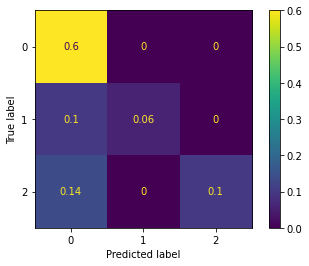

In [284]:
lr_cm = confusion_matrix(Y_test, lr_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,display_labels=[0,1,2])
disp.plot()

## Logistic Regression with SMOTE

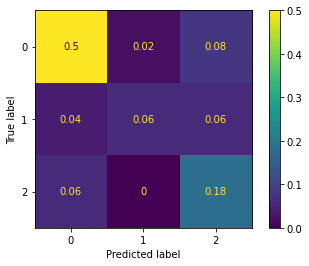

In [285]:
lr_sm_cm = confusion_matrix(Y_test, lr_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_sm_cm,display_labels=[0,1,2])
disp.plot()

## Gradient Boosting Classifier

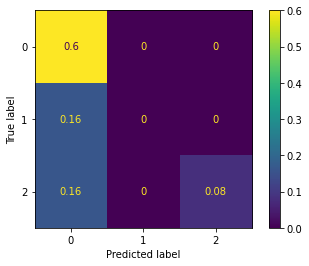

In [286]:
gb_cm = confusion_matrix(Y_test, gb_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm,display_labels=[0,1,2])
disp.plot()

## Gradient Boosting Classifier with SMOTE

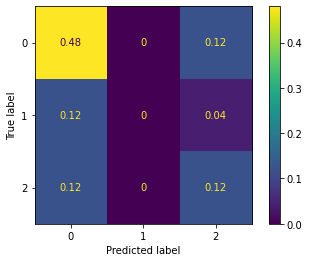

In [287]:
gb_sm_cm = confusion_matrix(Y_test, gb_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_sm_cm,display_labels=[0,1,2])
disp.plot()

# V. Application
Choose the best model and save the predictions in wrongpred.csv. 

There is also the need to note that using SMOTE entails drawing a random sample from the minority class, the precision and recall score of models with SMOTE vary per run. But, logistic regression with SMOTE remains to be the most correct predictor of the rank 2 class and less percentage of predicting rank 2 tweets as rank 0.

Taking this into account, it would be safer to predict that a rank 0 is rank 1 or 2 than predict otherwise.  Hence, the model with the least percentage of predicting rank 2 tweets as rank 0 was chosen, that is, the logistic regression with synthetic minority oversampling technique

In [288]:
# save predictions in csv file
wrong_pred = pd.DataFrame(X_test, columns =['content'])

wrong_pred.loc[:, 'coordinates'] = df['coordinates']
wrong_pred.loc[:, 'Latitude'] = df['Latitude']
wrong_pred.loc[:, 'Longitude'] = df['Longitude']
wrong_pred.loc[:, 'actual'] = Y_test
wrong_pred.loc[:, 'predicted'] = lr_pred_sm
wrong_pred.loc[:, 'new_score'] = wrong_pred['actual'] + (4* wrong_pred['predicted'])
wrong_pred.head()

wrong_pred.to_csv("wrongpred.csv")

In [289]:
print(wrong_pred['new_score'].value_counts())

0     25
10     9
8      4
9      3
5      3
2      3
1      2
4      1
Name: new_score, dtype: int64


### Extract tweets with rank = 2

In [290]:
df_locs = pd.DataFrame(columns = ['Latitude', 'Longitude'])
df_locs['Latitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Latitude']
df_locs['Longitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Longitude']

df_locs.head()

,Latitude,Longitude
39,10.5470262,124.7434968
80,10.5470262,124.7434968
10,10.2594754,123.7647381
0,10.5470262,124.7434968
18,10.7922629,124.8438494


### Plot the tweets in the geographical heatmap

The results below show that most of the plotted points were around Cebu and Leyte. The plotted points were also close to Baybay and Abuyog which specifically had the most casualties. Thus, we can say that the model worked for this dataset

In [291]:
fol_map = folium.Map(location=[10.847622263721211, 124.88887070186077], zoom_start=8)
markers = df_locs[['Latitude','Longitude']].values
fol_map.add_child(plugins.HeatMap(markers, radius=15))
fol_map